## Import Libraries

In [7]:
import pandas as pd
import numpy as np
import tensorflow as tf
import time
import matplotlib.pyplot as plt
from keras import Model
from keras.layers import Dense, Conv2D, Reshape, BatchNormalization, Activation, Input, LeakyReLU, Dropout, Flatten, Conv2DTranspose, concatenate
from tensorflow.keras.optimizers import Adam

## Model Architecture

In [8]:
class CGAN:
    def __init__(self, img_rows, img_cols, channels, num_classes, z, discriminator_steps=2, generator_steps=3):
        self.img_rows = img_rows
        self.img_cols = img_cols
        self.channels = channels
        self.num_classes = num_classes
        self.latent_dim = z
        self.discriminator_steps = discriminator_steps
        self.generator_steps = generator_steps
        self.img_shape = (img_rows, img_cols, channels)
        self.build_and_compile_models()
    
    def build_generator(self):
        """Build a Generator Model"""
        inputs = Input(shape=(self.latent_dim,))
        labels = Input(shape=(self.num_classes,))
        image_size = self.img_rows
        
        # Concatenate noise and label
        x = concatenate([inputs, labels], axis=1)
        x = Dense(image_size // 4 * image_size // 4 * 128)(x)
        x = Reshape((image_size // 4, image_size // 4, 128))(x)

        for filters in [128, 64, 32, self.channels]:
            strides = 2 if filters > 32 else 1
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            x = Conv2DTranspose(filters=filters, kernel_size=5, strides=strides, padding='same')(x)

        x = Activation('tanh')(x)
        generator = Model([inputs, labels], x, name='generator')
        generator.summary()
        return generator
    
    def build_discriminator(self):
        """Build a Discriminator Model"""
        inputs = Input(shape=self.img_shape)
        labels = Input(shape=(self.num_classes,))
        image_size = self.img_rows
        
        # Embed the labels
        y = Dense(image_size * image_size)(labels)  # Ensure this matches the flattened size
        y = Reshape((image_size, image_size, 1))(y)  # Correct shape
        
        x = concatenate([inputs, y])

        for filters in [32, 64, 128, 256]:
            strides = 2 if filters != 256 else 1
            x = Conv2D(filters=filters, kernel_size=5, strides=strides, padding='same')(x)
            x = LeakyReLU(alpha=0.2)(x)
            x = Dropout(0.4)(x)

        x = Flatten()(x)
        x = Dense(1)(x)
        x = Activation('sigmoid')(x)
        discriminator = Model([inputs, labels], x, name='discriminator')
        discriminator.summary()
        return discriminator


    def build_and_compile_models(self):
        """Build and compile Generator and Discriminator models"""
        # Build discriminator model
        self.discriminator = self.build_discriminator()
        optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        
        # Build generator model
        self.generator = self.build_generator()

        # Build adversarial model
        self.discriminator.trainable = False
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(self.num_classes,))
        img = self.generator([noise, label])
        validity = self.discriminator([img, label])
        self.combined = Model([noise, label], validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

### Loading weights

In [9]:
# Initialize the CGAN
cgan = CGAN(img_rows=28, img_cols=28, channels=1, num_classes=26, z=100)

# Load the weights into the generator, discriminator, or combined model
cgan.combined.load_weights('cgan_train_weights/cgan_Epoch_4900_combined.h5')

c:\Singapore Poly\DAAA2024S2\DOAA_DAAA\CA2_DOAA\ca2-daaa2b02-2309264-marcuslow\venv\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 26)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 784)       │     21,168 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_6       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 28, 28, 1) │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 28, 28, 2) │          0 │ input_layer_6[0]… │
│ (Concatenate)       │                   │            │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 14, 14,    │      1,632 │ concatenate_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 14, 14,    │          0 │ conv2d_4[0][0]    │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 14, 14,    │          0 │ leaky_re_lu_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 7, 7, 64)  │     51,264 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_5       │ (None, 7, 7, 64)  │          0 │ conv2d_5[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 7, 7, 64)  │          0 │ leaky_re_lu_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 4, 4, 128) │    204,928 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_6       │ (None, 4, 4, 128) │          0 │ conv2d_6[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 4, 4, 128) │          0 │ leaky_re_lu_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 4, 4, 256) │    819,456 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_7       │ (None, 4, 4, 256) │          0 │ conv2d_7[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 4, 4, 256) │          0 │ leaky_re_lu_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 4096)      │          0 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │      4,097 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 1)         │          0 │ dense_4[0][0]     │
│ (Activation)        │                   │            │                 

 Total params: 1,102,545 (4.21 MB)

 Trainable params: 1,102,545 (4.21 MB)

 Non-trainable params: 0 (0.00 B)

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_9       │ (None, 26)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 126)       │          0 │ input_layer_8[0]… │
│ (Concatenate)       │                   │            │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 6272)      │    796,544 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 7, 7, 128) │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 128) │        512 │ reshape_3[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_7        │ (None, 7, 7, 128) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 14, 14,    │    409,728 │ activation_7[0][… │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        512 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_8        │ (None, 14, 14,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_5  │ (None, 28, 28,    │    204,864 │ activation_8[0][… │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        256 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_9        │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_6  │ (None, 28, 28,    │     51,232 │ activation_9[0][… │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        128 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_10       │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_7  │ (None, 28, 28, 1) │        801 │ activation_10[0]… │
│ (Conv2DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,464,577 (5.59 MB)

 Trainable params: 1,463,873 (5.58 MB)

 Non-trainable params: 704 (2.75 KB)

## Function to Generate and save image grid

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def generate_image_grid(cgan_model, rows, cols, latent_dim, num_classes, save_path="cgan_collage_image/260_images_collage.png"):
    """
    Generates a grid of images using the CGAN model, displays it with column labels, and saves it as a PNG file.
    
    Parameters:
        cgan_model (CGAN): The CGAN model instance.
        rows (int): Number of rows in the grid.
        cols (int): Number of columns in the grid.
        latent_dim (int): Dimensionality of the latent vector.
        num_classes (int): Number of classes for one-hot encoding.
        save_path (str): Path to save the generated image grid.
    """
    
    # Generate noise and one-hot labels
    noise = np.random.normal(0, 1, (rows * cols, latent_dim))
    labels = np.zeros((rows * cols, num_classes))
    
    for i in range(rows):
        for j in range(cols):
            class_idx = j % num_classes  # Cycle through class indices
            labels[i * cols + j, class_idx] = 1  # One-hot encoding for each class
    
    # Generate images
    gen_imgs = cgan_model.generator.predict([noise, labels])
    
    # Rescale images to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    # Create a grid of images
    fig, axs = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    
    for i in range(rows):
        for j in range(cols):
            axs[i, j].imshow(gen_imgs[i * cols + j, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
    
    # Add labels at the top of each column
    alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for j in range(cols):
        axs[0, j].set_title(alphabet[j % len(alphabet)], fontsize=30)  # Add labels at the top

    # Adjust layout to fit labels and images tightly
    plt.tight_layout()
    
    # Save the grid as a PNG file
    fig.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.show()

    print(f"Image grid saved as {save_path}")


### Generate Images

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


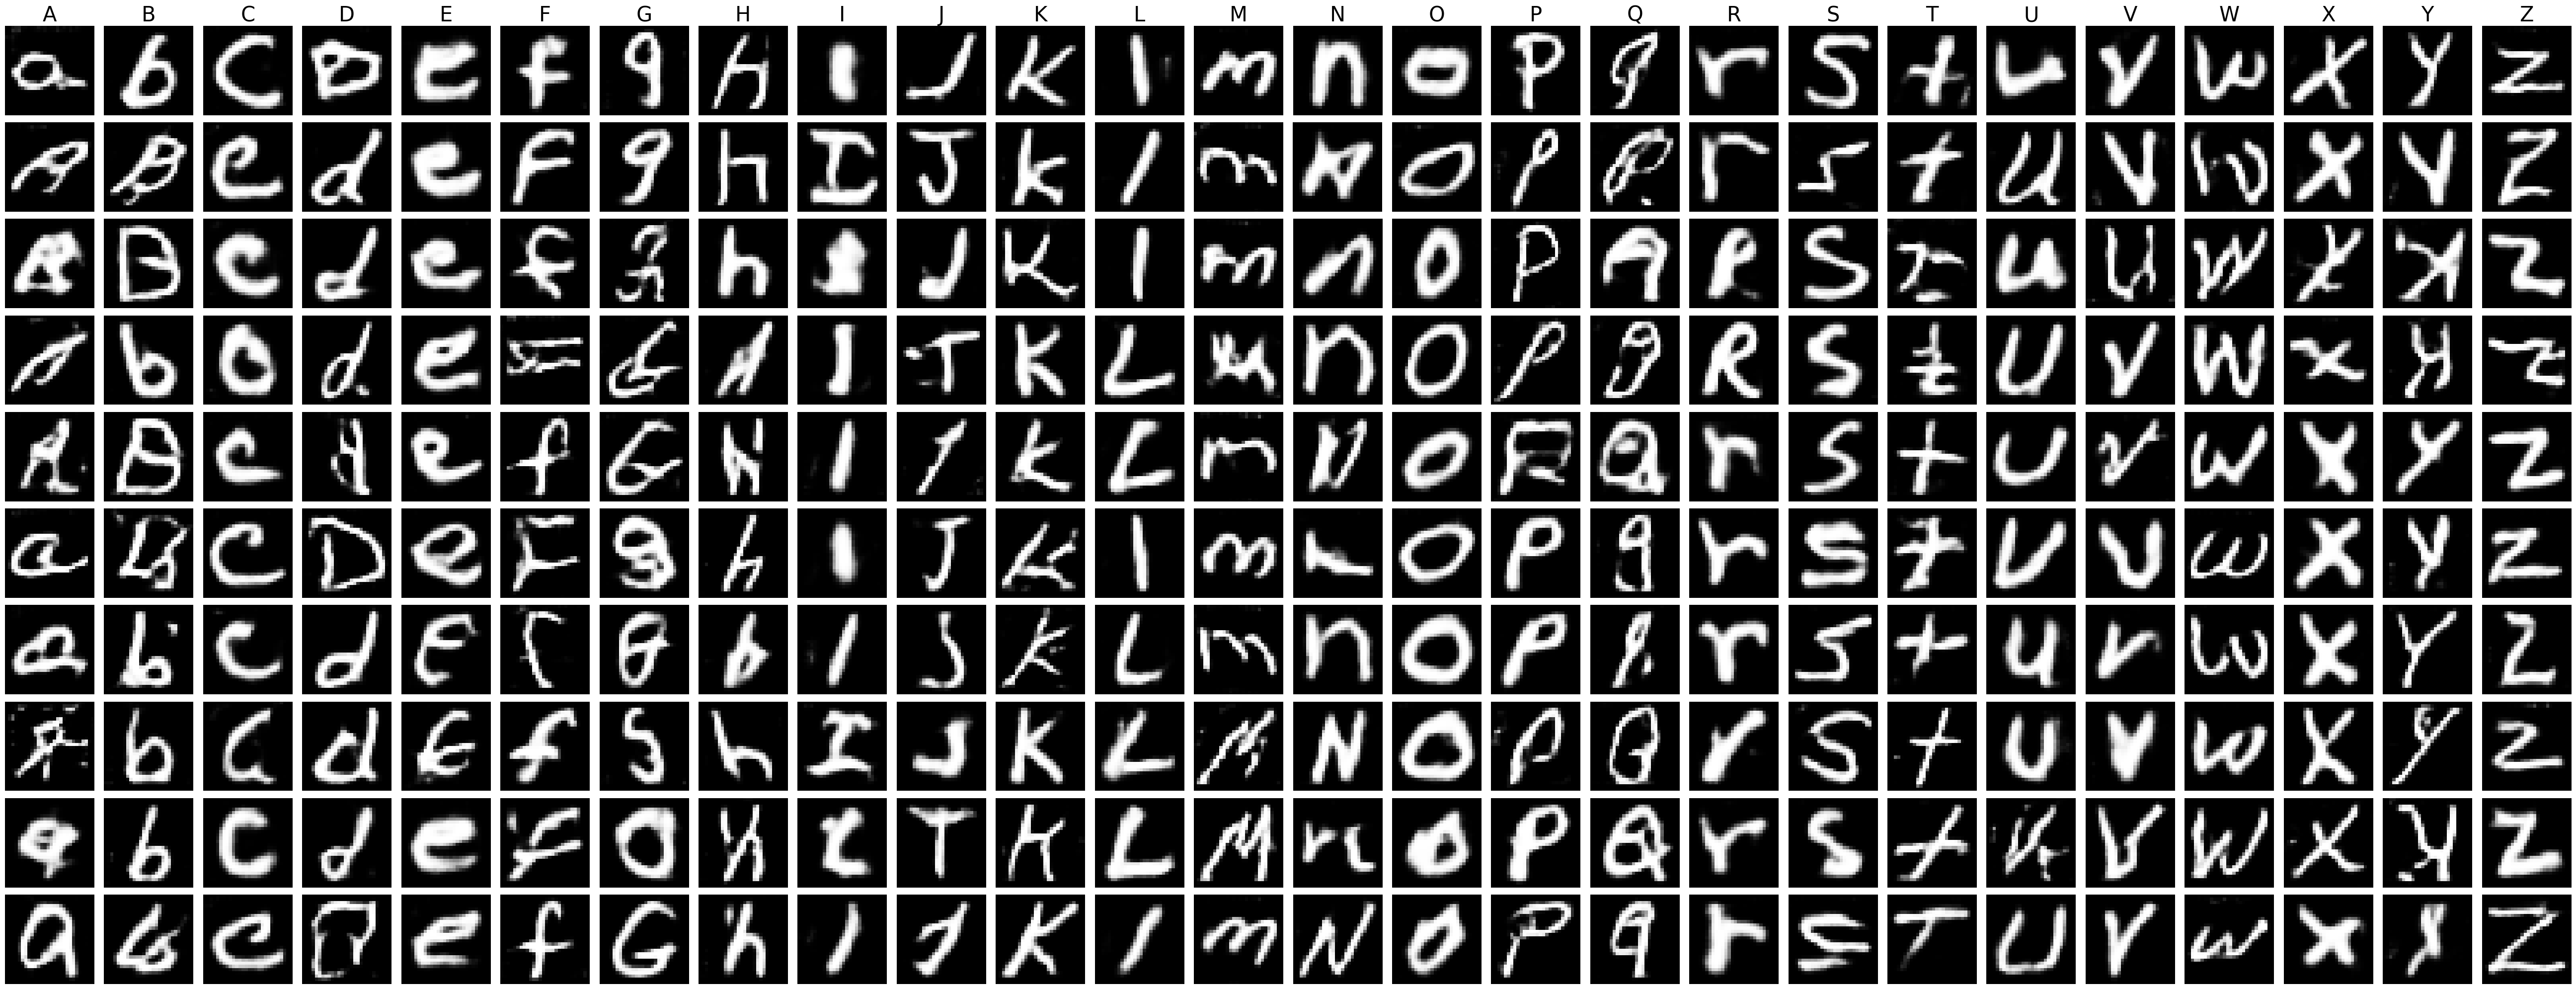

Image grid saved as cgan_collage_image/260_images_collage.png


In [11]:
# Generate and display the image grid
generate_image_grid(cgan, rows=10, cols=26, latent_dim=100, num_classes=26)

## Deployment to render process (show render link)

## Step 1: Export the Model for Tensorflow Serving

In [13]:
#save model
ts = int(time.time())
export_path = f"./saved_models/{ts}/"
tf.saved_model.save(cgan.combined, export_path)
print(f"Combined model saved to: {export_path}")

INFO:tensorflow:Assets written to: ./saved_models/1737043706/assets


INFO:tensorflow:Assets written to: ./saved_models/1737043706/assets


Combined model saved to: ./saved_models/1737043706/


## Step 2: Create Tensorflow Serving container by mounting the exported model

2.1 (Pull the Tensorflow Serving Docker image): 
- docker pull tensorflow/serving


2.2 (Run the TensorFlow Serving container, mounting the exported model):
- docker run --name=tf_serving_cgan -p 8501:8501 -v "C:/Singapore Poly/DAAA2024S2/DOAA_DAAA/CA2_DOAA/ca2-daaa2b02-2309264-marcuslow/saved_models:/models/saved_models" -e MODEL_NAME=saved_models -t tensorflow/serving

You should see something like this:
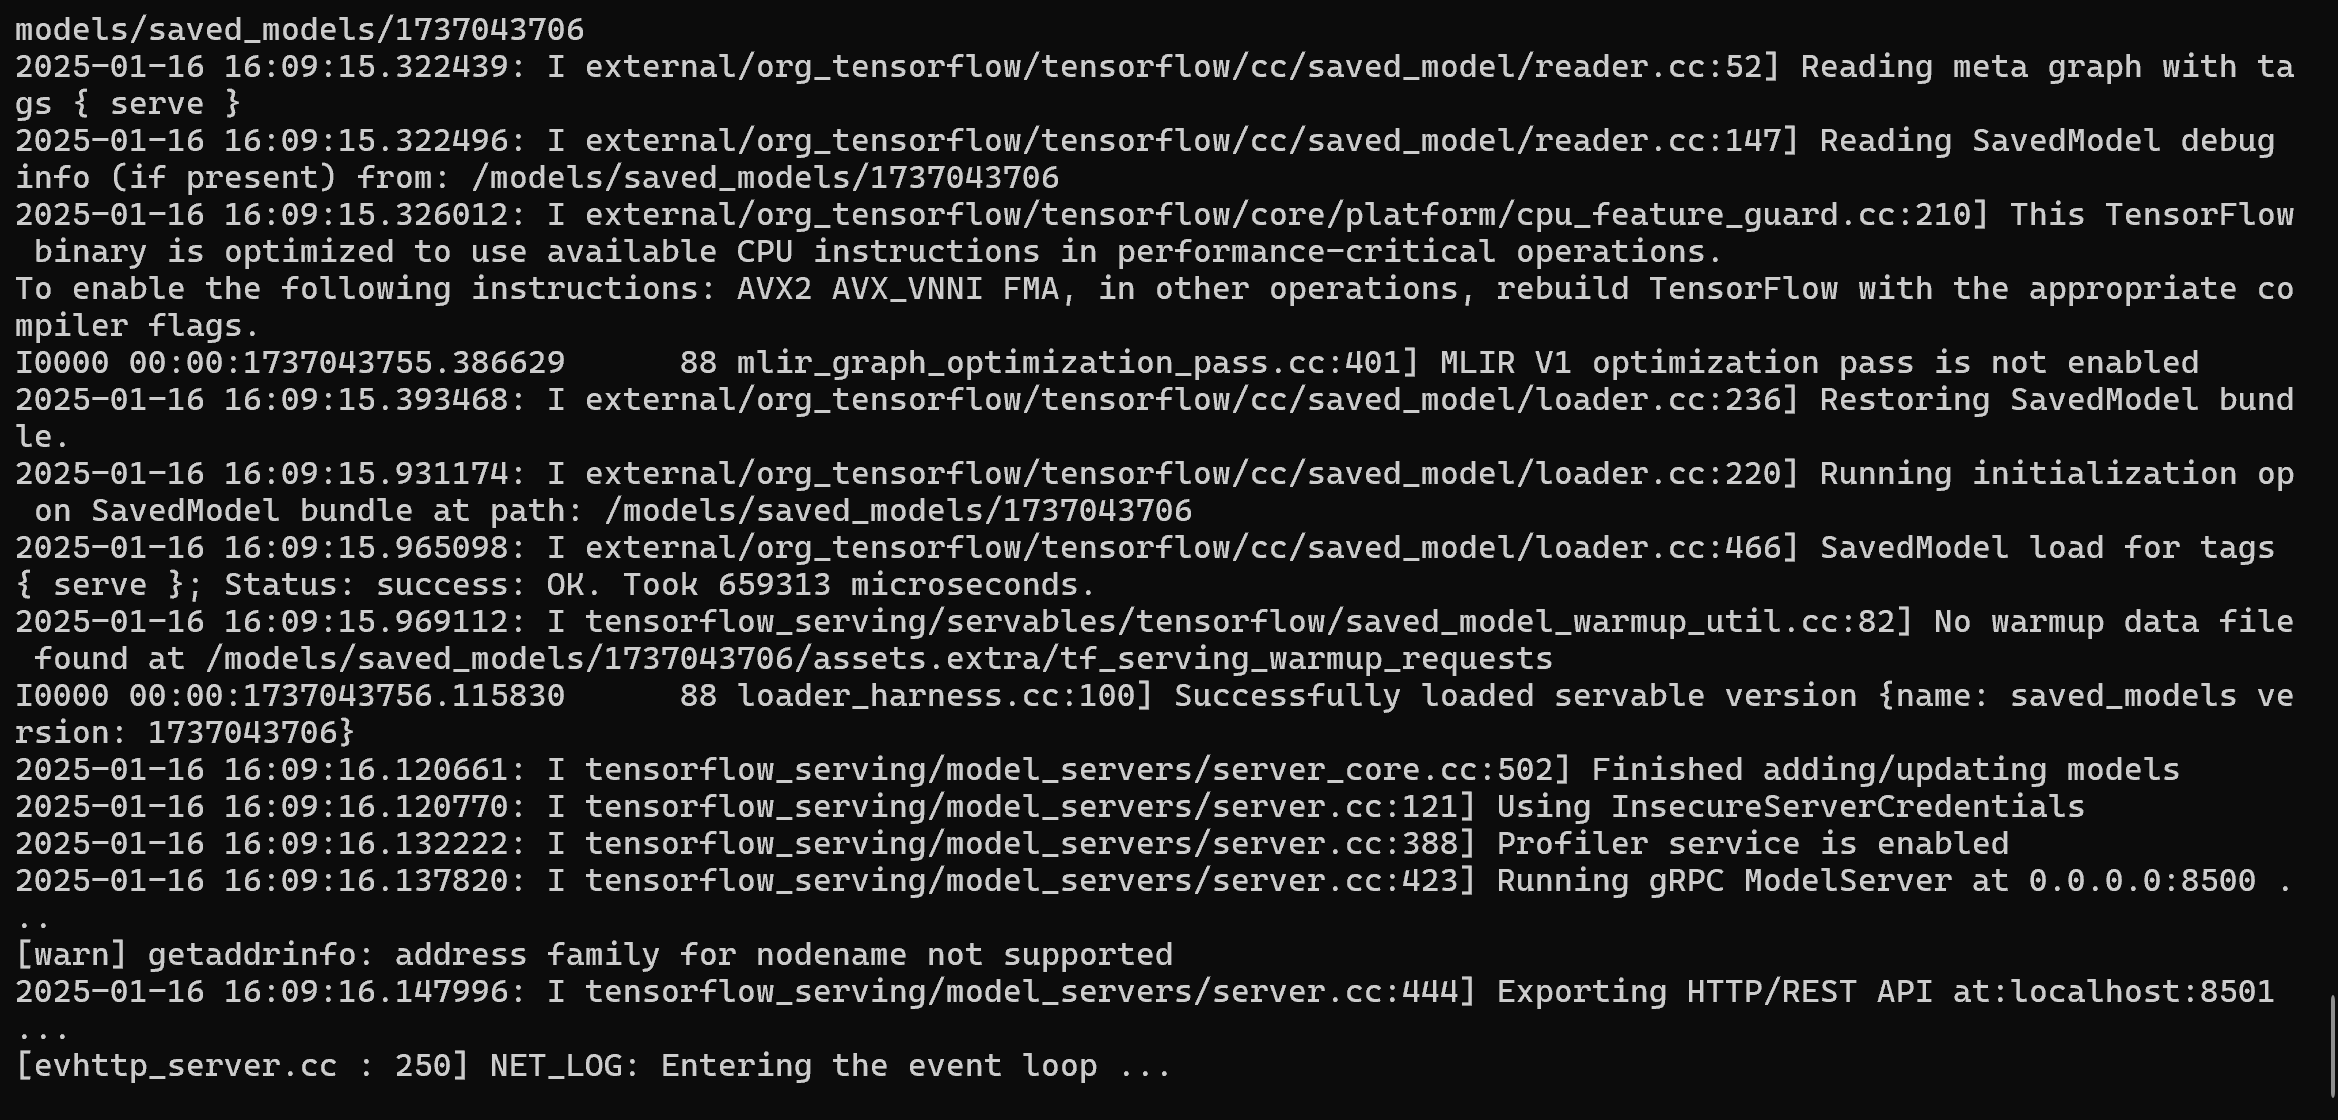

## Step 3: Using Render